In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# My imports
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2021-10-11 19:22:05.926004: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-11 19:22:05.926118: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

train_df['LotFrontage'] = train_df['LotFrontage'].fillna(np.mean(train_df['LotFrontage']))
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(np.mean(train_df['GarageYrBlt']))
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(np.mean(train_df['MasVnrArea']))
train_df['BsmtFullBath'] = train_df['BsmtFullBath'].fillna(0)
train_df['BsmtHalfBath'] = train_df['BsmtHalfBath'].fillna(0)
train_df['BsmtFinSF1'] = train_df['BsmtFinSF1'].fillna(0)
train_df['BsmtFinSF2'] = train_df['BsmtFinSF2'].fillna(0)
train_df['BsmtUnfSF'] = train_df['BsmtUnfSF'].fillna(0)
train_df['TotalBsmtSF'] = train_df['TotalBsmtSF'].fillna(0)
train_df['GarageCars'] = train_df['GarageArea'].fillna(0)
train_df['GarageCars'] = train_df['GarageArea'].fillna(0)

test_df['LotFrontage'] = test_df['LotFrontage'].fillna(np.mean(test_df['LotFrontage']))
test_df['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(np.mean(test_df['GarageYrBlt']))
test_df['MasVnrArea'] = test_df['MasVnrArea'].fillna(np.mean(test_df['MasVnrArea']))
test_df['BsmtFullBath'] = test_df['BsmtFullBath'].fillna(0)
test_df['BsmtHalfBath'] = test_df['BsmtHalfBath'].fillna(0)
test_df['BsmtFinSF1'] = test_df['BsmtFinSF1'].fillna(0)
test_df['BsmtFinSF2'] = test_df['BsmtFinSF2'].fillna(0)
test_df['BsmtUnfSF'] = test_df['BsmtUnfSF'].fillna(0)
test_df['TotalBsmtSF'] = test_df['TotalBsmtSF'].fillna(0)
test_df['GarageCars'] = test_df['GarageCars'].fillna(0)
test_df['GarageArea'] = test_df['GarageArea'].fillna(0)

missing_values = test_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
NAN_col = list(missing_values.to_dict().keys())
missing_values_data = pd.DataFrame(missing_values)
missing_values_data.reset_index(level=0, inplace=True)
missing_values_data.columns = ['Feature','Number of Missing Values']
missing_values_data['Percentage of Missing Values'] = (100.0*missing_values_data['Number of Missing Values'])/len(train_df)
print(missing_values_data)

missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
NAN_col = list(missing_values.to_dict().keys())
missing_values_data = pd.DataFrame(missing_values)
missing_values_data.reset_index(level=0, inplace=True)
missing_values_data.columns = ['Feature','Number of Missing Values']
missing_values_data['Percentage of Missing Values'] = (100.0*missing_values_data['Number of Missing Values'])/len(train_df)
print(missing_values_data)
    
all_features = test_df.columns.tolist()
all_features.append('SalePrice')
train_features = test_df.columns.tolist()
target = ['SalePrice']

Empty DataFrame
Columns: [Feature, Number of Missing Values, Percentage of Missing Values]
Index: []
Empty DataFrame
Columns: [Feature, Number of Missing Values, Percentage of Missing Values]
Index: []


In [3]:
# do some scaling
from sklearn.model_selection import train_test_split

scalar = MinMaxScaler()
train_df[all_features] = scalar.fit_transform(train_df[all_features])
multiplied_by = scalar.scale_[-1]
added = scalar.min_[-1]

test_df[target] = 100
test_df[all_features] = scalar.transform(test_df[all_features])
test_df.drop(columns=target, axis=1, inplace=True)


scaled_train_X = train_df[train_features]
scaled_train_y = train_df[target]
scaled_test_X = test_df[train_features]

X_train, X_val, y_train, y_val = train_test_split(scaled_train_X, scaled_train_y, test_size=0.001, random_state=0)

In [4]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    directory='model_dir',
    project_name='House_Price_Prediction')
 
tuner.search(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_val, y_val), verbose=1)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 00m 41s]
val_mse: 0.0002300363800410802

Best val_mse So Far: 7.802506055062015e-05
Total elapsed time: 00h 07m 38s


In [5]:
model = tuner.hypermodel.build(best_hps)

Epoch 1/100
46/46 [==============================] - 1s 4ms/step - loss: 0.0302 - mse: 0.0302
Epoch 2/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0032 - mse: 0.0032
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0024 - mse: 0.0024
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0019 - mse: 0.0019
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0015 - mse: 0.0015
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0014 - mse: 0.0014
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0011 - mse: 0.0011
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 8.2456e-04 - mse: 8.2456e-04
Epoch 10/100
46/46 [==============================] - 0s 5ms/step - loss: 7.1395e-04 - mse: 7.1395e-04
Epoch 11/100
46/46 [=======================

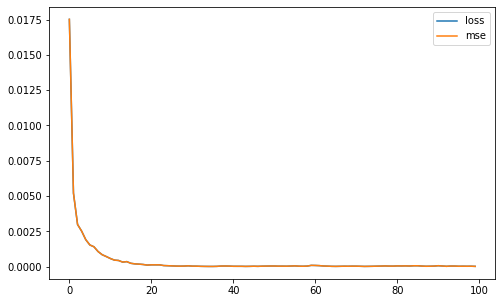

In [6]:
mod_history = model.fit(X_train, y_train, epochs=100, shuffle=True, verbose=1)
print(model.summary())

pd.DataFrame(mod_history.history).plot(figsize=(8,5))
plt.show()

In [7]:
prediction = model.predict(X_val)
y_0 = prediction
y_0 -= added
y_0 /= multiplied_by

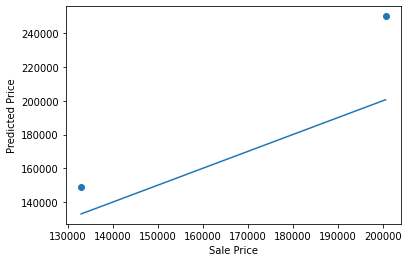

In [8]:
plt.scatter((y_val['SalePrice'] - added) / multiplied_by, y_0)
plt.xlabel('Sale Price')
plt.ylabel('Predicted Price')
plt.plot((y_val['SalePrice'] - added) / multiplied_by, (y_val['SalePrice'] - added) / multiplied_by)

In [9]:
#Create Submission
prediction = model.predict(scaled_test_X)
y_0 = prediction
y_0 -= added
y_0 /= multiplied_by
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

my_submission = pd.DataFrame({'Id': test_df.Id, 'SalePrice': y_0[:,0]})
my_submission.to_csv('submission.csv', index=False)